In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
from leapfrog import *

## Toy problem: time-dependent Hamiltonian system

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
# Parameters
mu = 0.249 * 2.0 * torch.pi  # rotation frequency
k3 = 2.0                     # octupole strength
period = 1.0                 # period of the system
s0 = 0.5                     # position of the perturbation

def hamiltonian_fn(q, p, s):
    H = mu / 2.0 * (q**2 + p**2) + k3 / 4.0 * torch.exp(-1000 * (s % period - s0)**2) * q**4
    return H

def q_prime(q, p, s):
    return mu * p

def p_prime(q, p, s):
    return -mu * q - k3 * torch.exp(-1000 * (s % period - s0)**2) * q**3

In [5]:
hamiltonian = Hamiltonian(hamiltonian_fn, q_prime, p_prime)
integrator = Leapfrog(hamiltonian, step_size=0.01)

In [6]:
steps = 200000
n_particles = 20

q = torch.zeros(n_particles, steps+1)
p = torch.zeros(n_particles, steps+1)

q[:, 0] = torch.linspace(0, 0.7, n_particles)
p[:, 0] = torch.zeros(n_particles)
for i in range(steps):
    q[:, i+1], p[:, i+1] = integrator.step(q[:, i], p[:, i], s=torch.tensor([i*integrator.step_size]))

Text(0, 0.5, 'p')

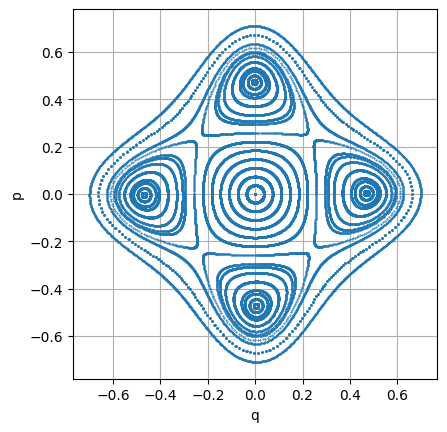

In [32]:
plt.plot(q.numpy()[:, ::100], p.numpy()[:, ::100], '.', markersize=1, color='C0')
plt.gca().set_aspect('equal')
plt.grid()
plt.xlabel('q')
plt.ylabel('p')

PDE given by continuity equation (Liouville's theorem) for the phase space density $\rho$:
$$
  \frac{\partial \rho}{\partial t} + \{H, \rho\} = 0.
$$

# Particle tracking simulations

In [ ]:
# load SPS sequence
line = xt.Line.from_json('sequence/sps_ft_q26.json')
line.build_tracker()

Loading line from dict: 100%|██████████| 18751/18751 [00:02<00:00, 9264.29it/s] 


Done loading line from dict.           


In [ ]:
# match tunes
line.match(
            method='4d',
            vary=[
                xt.VaryList(['kqf'], step=1e-8, tag='quad'),
                xt.VaryList(['kqd'], step=1e-8, tag='quad'),
            ],
            targets = [
                xt.TargetSet(qx=26.249, tol=1e-6, tag='tune'),
                xt.TargetSet(qy=26.578, tol=1e-6, tag='tune'),
            ])

                                             
Optimize - start penalty: 3.699                             
Matching: model call n. 9 penalty = 5.9895e-09              
Optimize - end penalty:  5.98952e-09                            


In [33]:
# set strength of octupolar perturbation
line['loe.10402'].k3 = 3.0

In [34]:
# track particles
particles = line.build_particles(x=np.linspace(0, 0.01, 20))
line.track(particles, num_turns=2000, turn_by_turn_monitor=True, freeze_longitudinal=True)
record = line.record_last_track

Text(0, 0.5, '$p_x$')

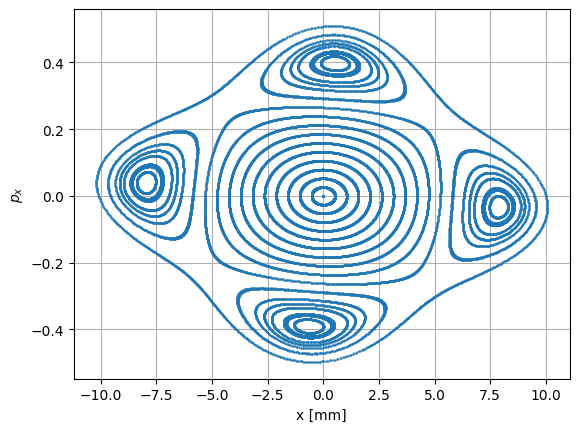

In [36]:
plt.plot(record.x[:, :] * 1000, record.px[:, :] * 1000, '.', markersize=1, color='C0')
plt.grid()
plt.xlabel('x [mm]')
plt.ylabel(r'$p_x$')